In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
import networkx as nx

# Set a random seed for reproducibility
np.random.seed(42)

def hindmarsh_rose(t, state, I, r):
    x, y, z = state
    dxdt = y + 3 * x ** 2 - x ** 3 - z + I
    dydt = 1 - 5 * x ** 2 - y
    dzdt = r * (4 * (x + 8 / 5) - z)
    return [dxdt, dydt, dzdt]


def integrate_hr(I, r, t_span, initial_conditions, dt=0.005):
    t_eval = np.arange(t_span[0], t_span[1], dt)
    solution = solve_ivp(hindmarsh_rose, t_span, initial_conditions, args=(I, r), t_eval=t_eval, method='RK45')
    return solution.t, solution.y[0]  # Return time and x(t)


def compute_isi(x, threshold=1.0):
    spikes = np.where((x[:-1] < threshold) & (x[1:] >= threshold))[0]
    isi = np.diff(spikes)
    return np.log(isi)



In [3]:

class EchoStateNetwork:
    def __init__(self, N_res=300, p=0.75, alpha=0.5, rho=0.85, lambda_ridge=1e-6):
        self.N_res = N_res
        self.p = p
        self.alpha = alpha
        self.rho = rho
        self.lambda_ridge = lambda_ridge
        self.Win = np.random.uniform(-0.5, 0.5, (N_res, 1))
        self.Wres = self._generate_reservoir()
        self.Wout = None

    def _generate_reservoir(self):
        G = nx.erdos_renyi_graph(self.N_res, self.p, directed=True)
        A = nx.to_numpy_array(G)
        A += np.eye(self.N_res)
        Wres = np.random.uniform(-0.5, 0.5, (self.N_res, self.N_res)) * A
        eigenvalues = np.abs(np.linalg.eigvals(Wres))
        max_eigenvalue = np.max(eigenvalues)
        Wres = Wres * (self.rho / max_eigenvalue)
        return Wres

    def _tanh_activation(self, x):
        return np.tanh(x)

    def train(self, u_train):
        N = len(u_train)
        x_res = np.zeros((N, self.N_res))
        state = np.zeros((self.N_res, 1))

        for t in range(N):
            state = (1 - self.alpha) * state + self.alpha * self._tanh_activation(
                np.dot(self.Win, u_train[t]) + np.dot(self.Wres, state))
            x_res[t] = state.squeeze()

        X_res_augmented = np.hstack([x_res, np.ones((N, 1))])  # Add bias
        ridge_regressor = Ridge(alpha=self.lambda_ridge, fit_intercept=False)
        ridge_regressor.fit(X_res_augmented, u_train)
        self.Wout = ridge_regressor.coef_

    def predict(self, u_initial, T_predict):
        state = np.zeros((self.N_res, 1))
        u_predict = np.zeros(T_predict)

        for t in range(T_predict):
            state = (1 - self.alpha) * state + self.alpha * self._tanh_activation(
                np.dot(self.Win, u_initial) + np.dot(self.Wres, state))
            u_initial = np.dot(np.hstack([state.squeeze(), 1]), self.Wout)
            u_predict[t] = u_initial

        return u_predict



In [4]:

def normalize(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    return (signal - mean) / std_dev, mean, std_dev


def denormalize(signal, mean, std_dev):
    return signal * std_dev + mean


def evaluate_esn(u_train, u_test, esn_params):
    esn = EchoStateNetwork(**esn_params)

    # Normalize the input signal
    u_train_normalized, mean, std_dev = normalize(u_train)

    # Train the ESN
    esn.train(u_train_normalized)

    # Predict future behavior
    u_pred_normalized = esn.predict(u_train_normalized[-1], len(u_test))

    # Denormalize the prediction
    u_pred = denormalize(u_pred_normalized, mean, std_dev)

    # Compute RMSE
    rmse = np.sqrt(np.mean((u_pred - u_test) ** 2))
    return rmse, u_pred


def generate_time_series():
    t_span = [0, 1500]
    initial_conditions = [-1.0, 2.0, 0.5]

    time_series = {}

    params = {
        '2a': (3.5, 0.003)
    }

    for key, (I, r) in params.items():
        _, x = integrate_hr(I, r, t_span, initial_conditions)
        time_series[key] = x[40000:]  # Discard transient time

    return time_series



In [5]:
def hyperparameter_tuning(time_series):
    Nres_values = np.linspace(300, 1500, 10).astype(int)
    p_values = np.linspace(0.1, 1.0, 10)
    alpha_values = np.linspace(0.1, 1.0, 10)
    rho_values = np.linspace(0.1, 1.5, 10)

    for key, u_train in time_series.items():
        u_test = u_train[len(u_train) // 2:]  # Split data into training and testing
        u_train = u_train[:len(u_train) // 2]

        # Function to handle the hyperparameter tuning and plotting
        def tune_and_plot(param_name, param_values, fixed_params):
            rmse_values = []
            for param_value in param_values:
                esn_params = fixed_params.copy()
                esn_params[param_name] = param_value
                rmse, _ = evaluate_esn(u_train, u_test, esn_params)
                rmse_values.append(rmse)

            # Find minimum RMSE and its corresponding parameter value
            min_rmse = np.min(rmse_values)
            min_param = param_values[np.argmin(rmse_values)]

            plt.figure(figsize=(10, 6))
            plt.plot(param_values, rmse_values, marker='o')
            plt.title(f'Prob-B-1a: RMSE vs {param_name} - Best {param_name}: {min_param} (RMSE: {min_rmse:.4f})')
            plt.xlabel(param_name)
            plt.ylabel('RMSET')
            plt.grid(True)
            plt.savefig(f'Prob-B-1a_{param_name}.png')
            plt.show()

            return min_rmse, min_param

        # Print the best parameter values and their corresponding RMSEs
        min_rmse_N_res, best_N_res = tune_and_plot('N_res', Nres_values, {'p': 0.75, 'alpha': 0.5, 'rho': 0.85, 'lambda_ridge': 1e-6})
        min_rmse_p, best_p = tune_and_plot('p', p_values, {'N_res': best_N_res, 'alpha': 0.5, 'rho': 0.85, 'lambda_ridge': 1e-6})
        min_rmse_alpha, best_alpha = tune_and_plot('alpha', alpha_values, {'N_res': best_N_res, 'p': best_p, 'rho': 0.85, 'lambda_ridge': 1e-6})
        min_rmse_rho, best_rho = tune_and_plot('rho', rho_values, {'N_res': best_N_res, 'p': best_p, 'alpha': best_alpha, 'lambda_ridge': 1e-6})

        print(f"Minimum RMSEs for {key}:")
        print(f"N_res={best_N_res}, RMSE={min_rmse_N_res:.4f}")
        print(f"p={best_p}, RMSE={min_rmse_p:.4f}")
        print(f"alpha={best_alpha}, RMSE={min_rmse_alpha:.4f}")
        print(f"rho={best_rho}, RMSE={min_rmse_rho:.4f}")
        print("-" * 50)


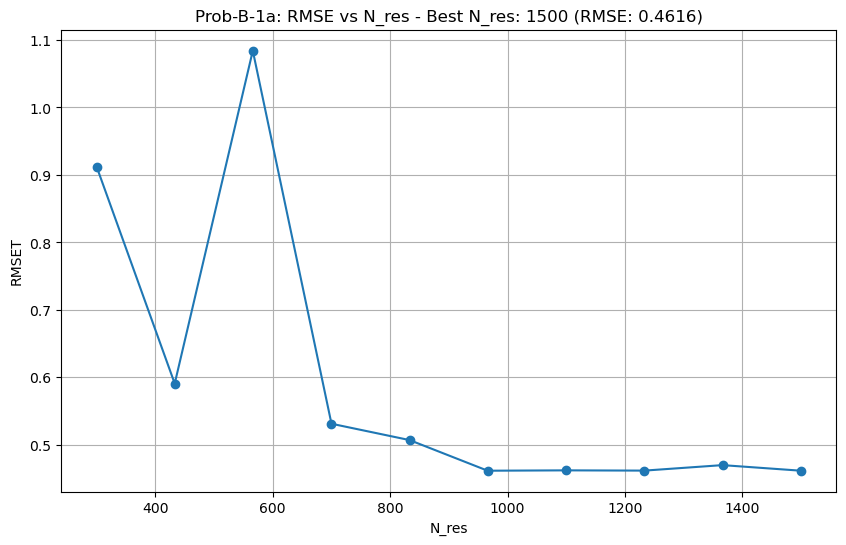

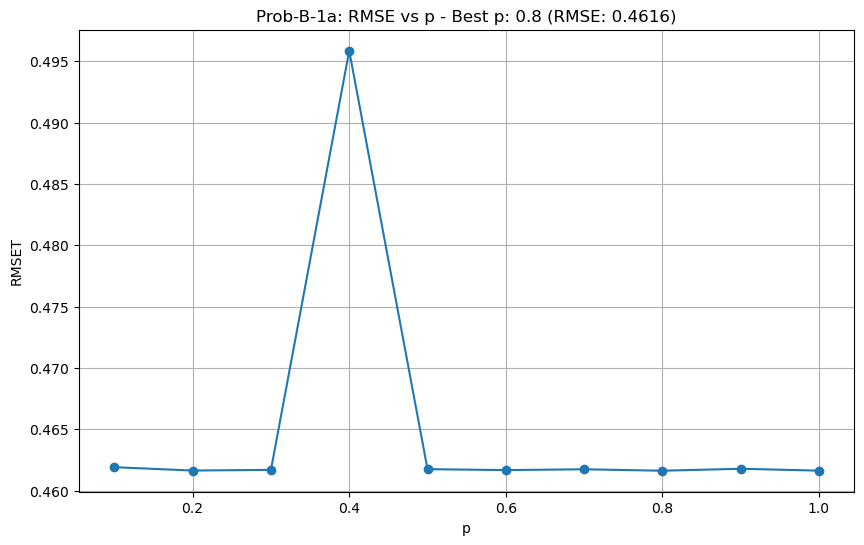

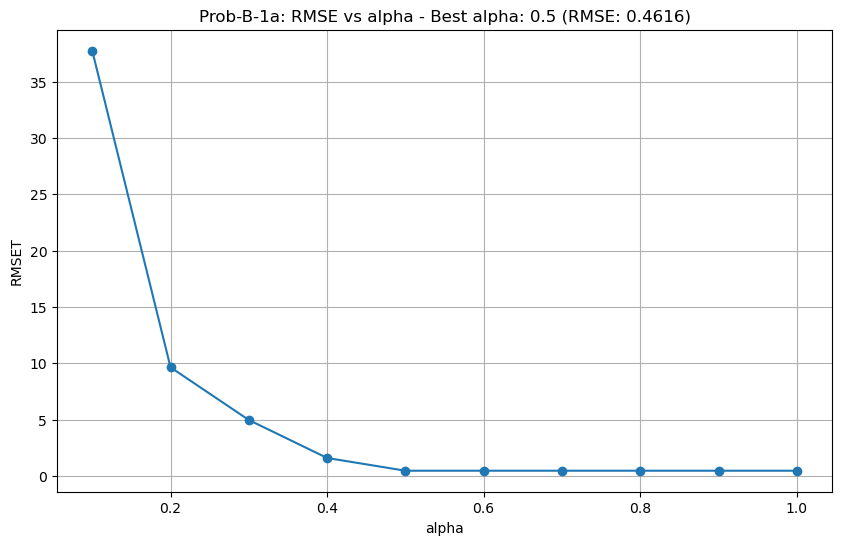

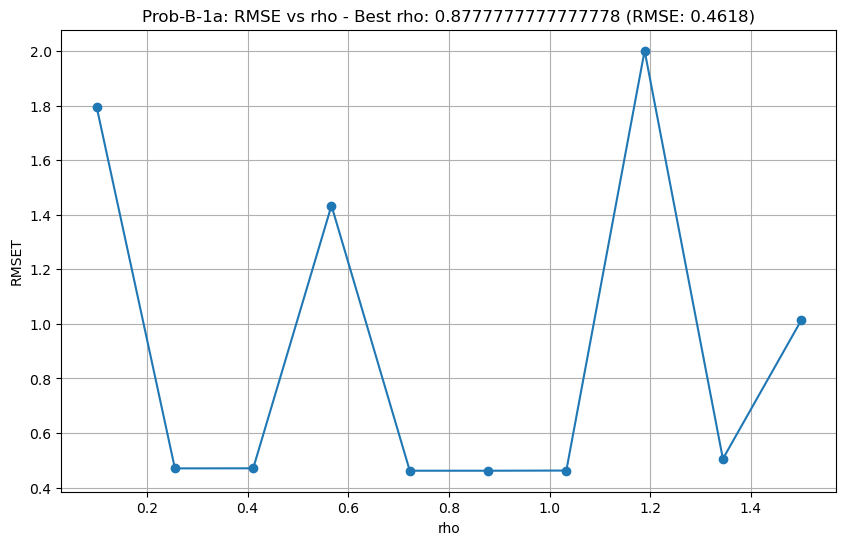

Minimum RMSEs for 2a:
N_res=1500, RMSE=0.4616
p=0.8, RMSE=0.4616
alpha=0.5, RMSE=0.4616
rho=0.8777777777777778, RMSE=0.4618
--------------------------------------------------


In [10]:

# Generate time series data and run hyperparameter tuning
time_series = generate_time_series()
hyperparameter_tuning(time_series)
